In [1]:
import keras
from keras import models, layers
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
from scipy.ndimage import imread
from scipy.misc import imresize
from nbutil import imshow_multi
from PIL import Image
import random

Using TensorFlow backend.


In [2]:
def to_pil(img):
    if img.shape[-1] == 1:
        img = img[:,:,0] # these are grayscale
    return Image.fromarray(np.clip(img * 255, 0, 255).astype(np.uint8))

In [3]:
data_dir = '../data/proj6/data/15SceneData'
categories = [c for c in os.listdir(os.path.join(data_dir, 'train')) if c[0] != '.']

SIZE = 64

def load_dataset(name):
    images = []
    labels = []
    for cat in categories:
        for filename in os.listdir(os.path.join(data_dir, name, cat)):
            if filename.endswith('.jpg'): 
                path = os.path.join(data_dir, name, cat, filename)
                image = imread(path)
                h,w = image.shape[:2]
                # top-left crop
                if h > w:
                    image = image[:w, :]
                else:
                    image = image[:, :h]
                image = imresize(image, size=[SIZE, SIZE], mode='L')
                images.append(image)
                labels.append(categories.index(cat))
    images = np.expand_dims(np.stack(images) / 255.0, -1)
    labels = np.expand_dims(np.stack(labels).astype(int), -1)
    return images, labels

trainx, trainy = load_dataset('train')
testx, testy = load_dataset('test')


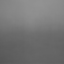

In [4]:
image_gen = ImageDataGenerator(rotation_range=10, 
                               zoom_range=0.2, 
                               width_shift_range=0.15, 
                               height_shift_range=0.15, 
                               horizontal_flip=True,
                               channel_shift_range=0.15)
# samplewise centering is broken in keras (https://github.com/fchollet/keras/issues/4047)
# so do it manually:
mean_img = np.mean(trainx, axis=0)
to_pil(mean_img)

In [5]:
# for x in image_gen.flow(trainx):
#     p = to_pil(x[0])
#     break
# p

In [6]:
input = layers.Input(shape=(SIZE, SIZE, 1))
x = input
y_dim = len(categories)

l2 = keras.regularizers.l2(0.01)

def conv(x, chans, ksize=3):
    return layers.Conv2D(chans, (ksize, ksize), activation='elu', padding='SAME', kernel_regularizer=l2)(x)

def conv_chain(x, chans, ksizes, average_pool_before=1):
    if average_pool_before > 1:
        x = layers.AveragePooling2D((average_pool_before, average_pool_before), strides=(1,1), padding='SAME')(x)
    for ksize in ksizes:
        x = conv(x, chans, ksize)
    return x

def layer(x, channels):
    c = int(channels/4)
    branch1 = conv_chain(x, c, [1])
    branch2 = conv_chain(x, c, [1, 3])
    branch3 = conv_chain(x, c, [1, 3, 3])
    branch4 = conv_chain(x, c, [1], average_pool_before=3)
    
    x = layers.Concatenate()([branch1, branch2, branch3, branch4])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    return x

for chans, pooling in [(64, 2), (64, 2), (64, 2), (64, 2), (64, 4)]:
    x = layer(x, chans)
    x = layers.AveragePooling2D((pooling, pooling), padding='SAME')(x)
    print(x.shape)

x = layers.Flatten()(x)
x = layers.Dense(y_dim * 4, activation='relu', kernel_regularizer=l2)(x)
x = layers.Dense(y_dim, activation='softmax', kernel_regularizer=l2)(x)
print(x.shape)
model = models.Model(inputs=[input], outputs=[x])

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])
model.summary()

(?, 32, 32, 64)
(?, 16, 16, 64)
(?, 8, 8, 64)
(?, 4, 4, 64)
(?, 1, 1, 64)
(?, 15)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
conv2d_4 (Conv2D)                (None, 64, 64, 16)    32                                           
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 64, 64, 16)    32                                           
____________________________________________________________________________________________________
conv2d_5 (Conv2D)                (None, 64, 64, 16)    2320                                         
_________

In [7]:
# at epoch 53: loss: 1.3118601918819561, accuracy: 0.6830820771118304

batch_size = 32

for i in range(80):
    lr = 1e-4
    if i > 50:
        lr = 1e-4/2
    model.optimizer.lr.assign(lr)
    model.fit_generator(image_gen.flow(trainx - mean_img, trainy, batch_size=batch_size),
                       steps_per_epoch=len(trainx)/batch_size,
                       verbose=0,
                       workers=2,
                       epochs=1)
    if i % 1 == 0:
        score = model.evaluate(testx - mean_img, testy, verbose=0)
        print('epoch: {}, loss: {}, accuracy: {}'.format(i+1, score[0], score[1]))

epoch: 1, loss: 8.577203482878668, accuracy: 0.10586264656616415
epoch: 2, loss: 7.257595150434791, accuracy: 0.08207705192629816
epoch: 3, loss: 6.276280940517508, accuracy: 0.06164154103852596
epoch: 4, loss: 5.50952709459979, accuracy: 0.0797319932998325
epoch: 5, loss: 4.947993068758966, accuracy: 0.11658291457286432
epoch: 6, loss: 4.489604321836027, accuracy: 0.11993299832495813
epoch: 7, loss: 4.152666425305595, accuracy: 0.13802345058626467
epoch: 8, loss: 3.9675499650900887, accuracy: 0.06264656616415411
epoch: 9, loss: 3.788694750963144, accuracy: 0.09514237855946399
epoch: 10, loss: 3.4613949064034313, accuracy: 0.16683417085427135
epoch: 11, loss: 3.2885703756182236, accuracy: 0.19497487437185929
epoch: 12, loss: 3.046450749354147, accuracy: 0.1882747068676717
epoch: 13, loss: 3.098270160269298, accuracy: 0.18592964824120603
epoch: 14, loss: 3.0999653808235923, accuracy: 0.16214405360134004
epoch: 15, loss: 3.051450450775811, accuracy: 0.16314907872696818
epoch: 16, loss: 3

KeyboardInterrupt: 

In [ ]:
score = model.evaluate(testx, testy, verbose=0)
print 'accuracy: {}'.format(score[1])